In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

# Companies

## Feature Engineering
After one-hot encoding, the companies dataset has 995 columns, so it's necessary to perform dimensionality reduction before building the model.

In [29]:
pd.set_option('display.max_columns', None)
companies_df = pd.read_csv("data/companies.csv")
companies_df.head()

,Unnamed: 0,Target Account,Number of times contacted,ICP Fit Level,Record ID,Number of Pageviews,Number of Sessions,Web Technologies_Oracle Commerce Cloud,Web Technologies_The Trade Desk,Web Technologies_Dropbox,Web Technologies_Tableau,Web Technologies_Yahoo Stores,Web Technologies_Bing Ads,Web Technologies_IBM WebSphere,Web Technologies_Amazon Associates,Web Technologies_JW Player,Web Technologies_Microsoft Dynamics,Web Technologies_Snowplow Analytics,Web Technologies_Snowflake,Web Technologies_webMethods,Web Technologies_Add To Any,Web Technologies_Contently,Web Technologies_Castle,Web Technologies_NCR Retail,Web Technologies_Acquia,Web Technologies_Magento,Web Technologies_WordPress Stats,Web Technologies_Tealium,Web Technologies_IBM InfoSphere DataStage,Web Technologies_Matomo,Web Technologies_Ooyala,Web Technologies_HBase,Web Technologies_SailPoint,Web Technologies_Demandware,Web Technologies_Influitive,Web Technologies_Greenhouse,Web Technologies_Google Apps,Web Technologies_Outbrain Ads,Web Technologies_Namecheap Dns,Web Technologies_Dailymotion,Web Technologies_Conversio,Web Technologies_Classy,Web Technologies_GetResponse,Web Technologies_Track JS,Web Technologies_Akamai,Web Technologies_Customer.io,Web Technologies_Adobe Business Catalyst,Web Technologies_Wp Engine,Web Technologies_Heroku,Web Technologies_Bigcommerce,Web Technologies_Google Adwords,Web Technologies_Hello Bar,Web Technologies_DB2,Web Technologies_NICE inContact,Web Technologies_Oracle Fusion,Web Technologies_Okta,Web Technologies_WebTrends,Web Technologies_SalesLoft,Web Technologies_Apache Tomcat,Web Technologies_Resumator,Web Technologies_Disqus,Web Technologies_Fullcontact,Web Technologies_Rubicon Project,Web Technologies_Adobe Dynamic Tag Management,Web Technologies_TIBCO Rendezvous,Web Technologies_SOASTA,Web Technologies_Turn,Web Technologies_DoubleClick Advertiser,Web Technologies_SpeedCurve,Web Technologies_CacheFly,Web Technologies_SAP Business Objects,Web Technologies_Piwik,Web Technologies_Magnolia CMS,Web Technologies_Dotmailer,Web Technologies_WhosOn,Web Technologies_Monetate,Web Technologies_Aweber,Web Technologies_Convio,Web Technologies_ShareThis,Web Technologies_Linode Hosting,Web Technologies_amCharts,Web Technologies_Microsoft Project,Web Technologies_Splunk,Web Technologies_Marchex,Web Technologies_Terminus,Web Technologies_Google Tag Manager,Web Technologies_Microsoft Power BI,Web Technologies_Gocardless,Web Technologies_Sage Intacct,Web Technologies_Baidu Analytics,Web Technologies_Outbound,Web Technologies_Nimsoft,Web Technologies_CJ Affiliate,Web Technologies_Yesware,Web Technologies_Podio,Web Technologies_PeopleSoft CRM,Web Technologies_F5 BIG-IP,Web Technologies_Yieldify,Web Technologies_Olark,Web Technologies_Autopilot,Web Technologies_Uber Cart,Web Technologies_Zoho CRM,Web Technologies_Ceridian,Web Technologies_Intercom,Web Technologies_Workable,Web Technologies_NS1,Web Technologies_Bizo,Web Technologies_Joomla,Web Technologies_Atlassian JIRA,Web Technologies_Klarna,Web Technologies_IBM WebSphere Commerce,Web Technologies_Icims,Web Technologies_Listrak,Web Technologies_ios,Web Technologies_Fastly,Web Technologies_Qualaroo,Web Technologies_ownerIQ,Web Technologies_Facebook Like Button,Web Technologies_Couchbase,Web Technologies_Verticalresponse,Web Technologies_Iterable,Web Technologies_Fortinet,Web Technologies_Salesforce Servlet WebToCase,Web Technologies_Adscale,Web Technologies_SAP Concur,Web Technologies_Cision,Web Technologies_Braintree,Web Technologies_Atlassian Crowd,Web Technologies_Highcharts,Web Technologies_Flowplayer,Web Technologies_AWS Redshift,Web Technologies_AppDynamics,Web Technologies_Smartsheet,Web Technologies_Extend,Web Technologies_TIBCO Spotfire,Web Technologies_RingCentral,Web Technologies_JHA Payment Solutions,Web Technologies_Polldaddy,Web Technologies_Silkroad,Web Technologies_PayPal,Web Technologies_Unix,Web Technologies_flashtalking,Web Technologies_Sage CRM,Web Technologies_Marketo,Web Techno

In [30]:
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10584 entries, 0 to 10583
Columns: 995 entries, Unnamed: 0 to Close YN
dtypes: int64(995)
memory usage: 80.3 MB


In [31]:
# Drop some columns if present
if "Unnamed: 0" in companies_df.columns:
    companies_df = companies_df.drop(columns=["Unnamed: 0"])

if "Record ID" in companies_df.columns:
    companies_df = companies_df.drop(columns=["Record ID"])

In [32]:
# Extract features and target
X = companies_df.drop(columns=["Close YN"])
y = companies_df["Close YN"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

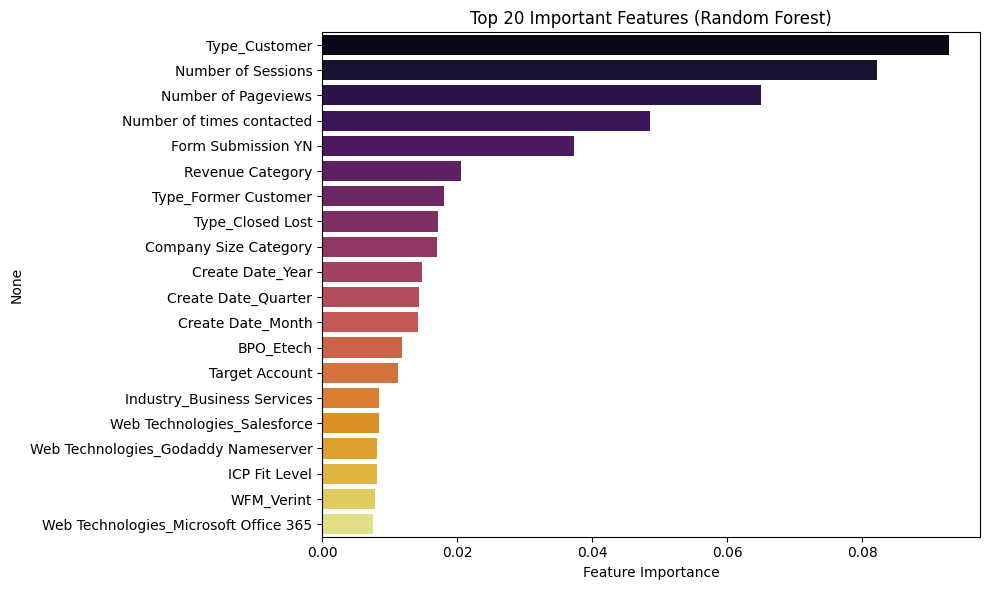

In [33]:
# Train RandomForest to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Top 20 features
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

# Plot top 20 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue = top_features.index, palette="inferno")
plt.title("Top 20 Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

### Feature Importance Analysis (Random Forest)

The bar chart you saw highlights the **Top 20 most important features** for predicting whether a deal is closed (`Close YN`). Here's a summary of what the key features indicate:

| **Feature** | **Interpretation** |
|-------------|--------------------|
| `Type_Customer`, `Type_Former Customer` | The type of customer has a significant impact on the likelihood of closing a deal. For example, returning customers or those categorized as “Customer” may be more likely to close. |
| `Number of Sessions`, `Number of Pageviews` | These engagement metrics are strong indicators of customer interest. More sessions and pageviews often correlate with higher conversion likelihood. |
| `Form Submission YN` | Whether the customer submitted a form can reflect strong buying intent. Lack of form submission may indicate lower interest. |
| `Revenue Category`, `Company Size Category` | Company size and revenue level are positively related to purchasing power and decision-making capability. Larger and higher-revenue companies tend to convert more easily. |
| `Web Technologies_*` | The presence of certain deployed web technologies may indicate technical maturity or readiness, which contributes to a higher probability of closing a deal. |

---

#### Summary

> These top features not only reflect who the customer is (company profile), but also **how actively they engage** with the product and **what signals they send** during the journey. This makes them powerful predictors in a sales enablement model.


## Xgboost

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2107
           1       0.75      0.60      0.67        10

    accuracy                           1.00      2117
   macro avg       0.87      0.80      0.83      2117
weighted avg       1.00      1.00      1.00      2117

Confusion Matrix:
 [[2105    2]
 [   4    6]]
AUC Score: 0.9902705268153773


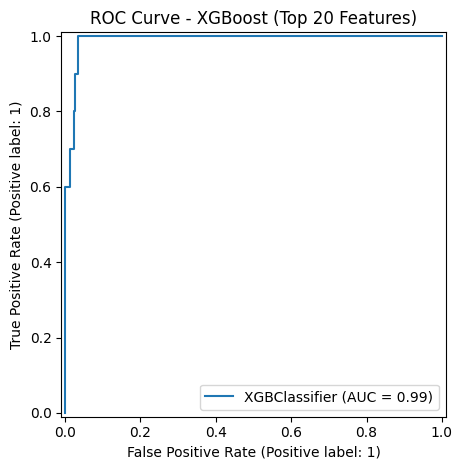

In [38]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

X_selected = companies_df[top_features.index]
y = companies_df["Close YN"]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("ROC Curve - XGBoost (Top 20 Features)")
plt.tight_layout()
plt.show()

This block trains an XGBoost binary classification model using the top 20 features selected from feature importance. 

The dataset is highly imbalanced, with only 0.5% of deals marked as “Closed Won”. The model becomes biased toward predicting “not closed” because it's the dominant class. The recall for closed deals is only 60%, which means many real customers are missed. Missing positive predictions could mean losing real sales opportunities.

Classification Report with Balanced Class Weight:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2107
           1       0.62      0.80      0.70        10

    accuracy                           1.00      2117
   macro avg       0.81      0.90      0.85      2117
weighted avg       1.00      1.00      1.00      2117

Confusion Matrix:
 [[2102    5]
 [   2    8]]
AUC Score: 0.9900806834361652


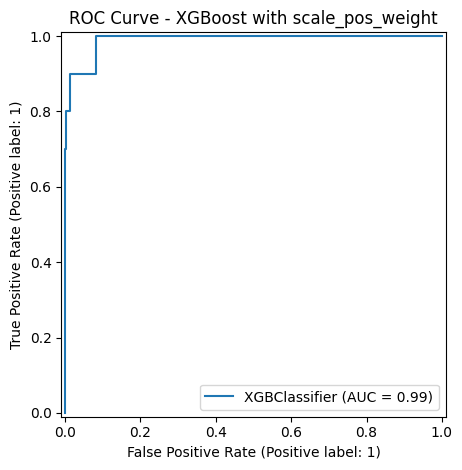

In [39]:
positive_count = sum(y == 1)
negative_count = sum(y == 0)
scale_weight = negative_count / positive_count

xgb_model_balanced = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_weight,
    random_state=42
)

xgb_model_balanced.fit(X_train, y_train)

y_pred_bal = xgb_model_balanced.predict(X_test)
y_proba_bal = xgb_model_balanced.predict_proba(X_test)[:, 1]

print("Classification Report with Balanced Class Weight:\n", classification_report(y_test, y_pred_bal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))
print("AUC Score:", roc_auc_score(y_test, y_proba_bal))

RocCurveDisplay.from_estimator(xgb_model_balanced, X_test, y_test)
plt.title("ROC Curve - XGBoost with scale_pos_weight")
plt.tight_layout()
plt.show()

While recall has improved, precision dropped, meaning the model catches more positives but at the cost of more false alarms.

## Clustering & Visualization
I used the top 20 most important features from the classification task and applied KMeans clustering with 3 clusters. The features were standardized and visualized with PCA.

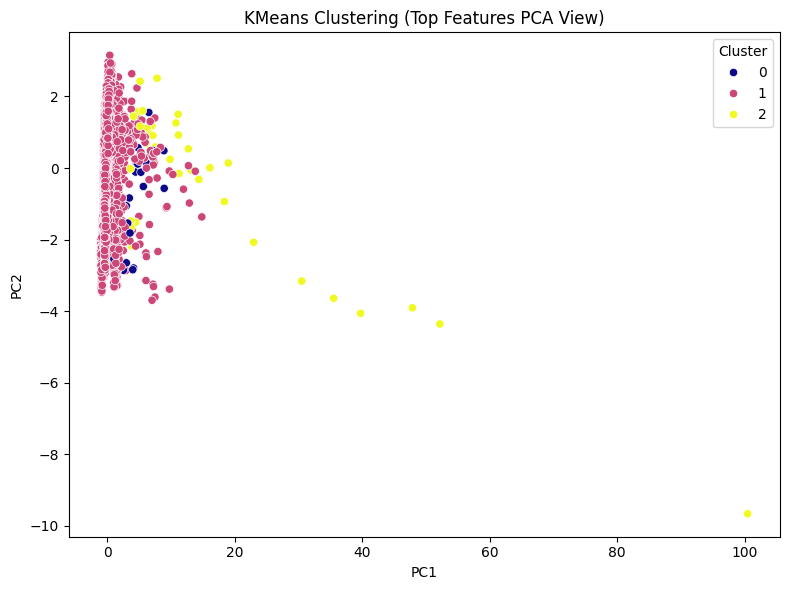

In [40]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

# Select top features used earlier
X_cluster = companies_df[top_features.index].copy()

# Standardize features before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Fit KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Assign cluster labels back to original dataframe
companies_df['Cluster'] = clusters

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Cluster"] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="plasma")
plt.title("KMeans Clustering (Top Features PCA View)")
plt.tight_layout()
plt.show()

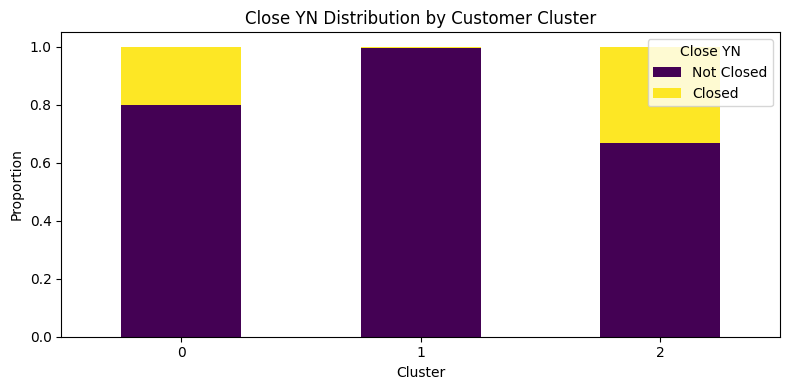

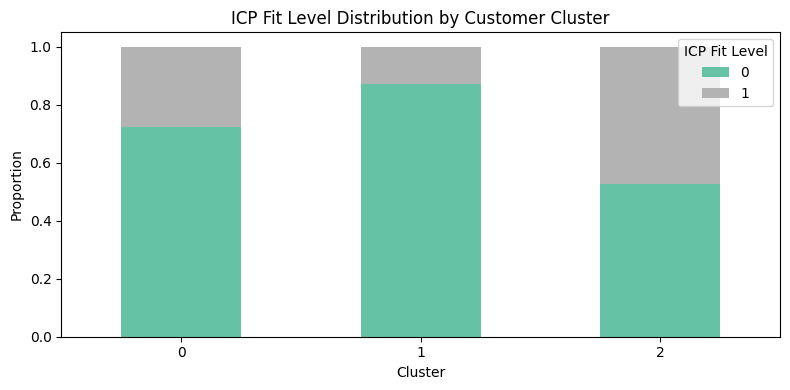

In [41]:
# Compare Close YN distribution by cluster
close_dist = companies_df.groupby("Cluster")["Close YN"].value_counts(normalize=True).unstack()

# Compare ICP Fit Level distribution by cluster
if "ICP Fit Level" in companies_df.columns:
    icp_dist = companies_df.groupby("Cluster")["ICP Fit Level"].value_counts(normalize=True).unstack()
else:
    icp_dist = None

# Visualize close ratio by cluster
close_dist.plot(kind="bar", stacked=True, colormap="viridis", figsize=(8, 4))
plt.title("Close YN Distribution by Customer Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.legend(title="Close YN", labels=["Not Closed", "Closed"])
plt.tight_layout()
plt.show()

# Visualize ICP distribution by cluster if available
if icp_dist is not None:
    icp_dist.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 4))
    plt.title("ICP Fit Level Distribution by Customer Cluster")
    plt.ylabel("Proportion")
    plt.xlabel("Cluster")
    plt.xticks(rotation=0)
    plt.legend(title="ICP Fit Level")
    plt.tight_layout()
    plt.show()

Cluster 2 is the top-performing segment, with the highest close rate and ICP fit. Cluster 1 may be deprioritized, and Cluster 0 is a mix needing further profiling.

# Deals

In [75]:
deals_df = pd.read_csv("data/deals.csv")
deals_df.head()

,Unnamed: 0,Weighted amount,Record ID,Deal probability,Is Closed Won,Is closed lost,Amount,Deal Stage,Deal Score_1,Deal Score_2,Deal Score_3,Deal Score_4,Deal Score_5,Deal source attribution 2_Customer Referral - Other,Deal source attribution 2_Customer Referral CSM,Deal source attribution 2_Email campaign,Deal source attribution 2_Event,Deal source attribution 2_Master Agent,Deal source attribution 2_Other,Deal source attribution 2_PAM,Deal source attribution 2_PLG,Deal source attribution 2_Referral Partner,Deal source attribution 2_Search,Deal source attribution 2_Social Media,Deal source attribution 2_SymTrain EE name,Deal source attribution 2_Verint Intro,Forecast category_Closed won,Forecast category_Commit,Forecast category_Not forecasted,Forecast category_Pipeline,Original Traffic Source_Offline Sources,Original Traffic Source_Organic Search,Original Traffic Source_Organic Social,Original Traffic Source_Other Campaigns,Original Traffic Source_Referrals,Create Date_Year,Create Date_Month,Create Date_Quarter,Deal Type_New,Deal Type_PS,Deal Type_Renewal
0,0,250.0,33774471298,0.20,0,0,1250.0,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2025,2,1,1,0,0
1,1,0.0,33735737768,0.05,0,0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,2025,2,1,1,0,0
2,2,0.0,33758455618,0.05,0,0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,2025,2,1,1,0,0
3,3,0.0,33741931267,0.05,0,0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,2025,2,1,1,0,0
4,4,10000.0,33724679941,0.20,0,0,50000.0,5,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2025,2,1,1,0,0


In [76]:
# Drop some columns if present
if "Unnamed: 0" in deals_df.columns:
    deals_df = deals_df.drop(columns=["Unnamed: 0"])

if "Record ID" in deals_df.columns:
    deals_df = deals_df.drop(columns=["Record ID"])

if "Is closed lost" in deals_df.columns:
    deals_df = deals_df.drop(columns=["Is closed lost"])

# Create expected value if relevant columns exist
if "Weighted amount" in deals_df.columns and "Deal probability" in deals_df.columns:
    deals_df["Expected Value"] = deals_df["Weighted amount"] * deals_df["Deal probability"]

In [77]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 39 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Weighted amount                                      573 non-null    float64
 1   Deal probability                                     593 non-null    float64
 2   Is Closed Won                                        593 non-null    int64  
 3   Amount                                               573 non-null    float64
 4   Deal Stage                                           593 non-null    int64  
 5   Deal Score_1                                         593 non-null    int64  
 6   Deal Score_2                                         593 non-null    int64  
 7   Deal Score_3                                         593 non-null    int64  
 8   Deal Score_4                                         593 non-null    i

In [96]:
# Calculate the class distribution in the target variable
deal_target_distribution = deals_df["Is Closed Won"].value_counts().to_frame(name="Count")
deal_target_distribution["Percentage"] = round(100 * deal_target_distribution["Count"] / deal_target_distribution["Count"].sum(), 2)
deal_target_distribution

,Count,Percentage
Is Closed Won,,
0,435,73.36
1,158,26.64


In [97]:
# Count how many rows have at least one missing value
num_rows_with_na = deals_df.isna().any(axis=1).sum()
total_rows = deals_df.shape[0]

num_rows_with_na, total_rows, round(num_rows_with_na / total_rows * 100, 2)  # Also return percentage of rows with NaNs

deals_df_cleaned = deals_df.dropna()

In [98]:
# Define features and label
X = deals_df_cleaned.drop(columns=["Is Closed Won"])
y = deals_df_cleaned["Is Closed Won"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
# XGBoost
xgb_model = XGBClassifier(eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)
logreg_pred = logreg_model.predict(X_test)
logreg_proba = logreg_model.predict_proba(X_test)[:, 1]



# Evaluate models
results = {
    "XGBoost": {
        "AUC": roc_auc_score(y_test, xgb_proba),
        "Classification Report": classification_report(y_test, xgb_pred, output_dict=True)
    },
    "Random Forest": {
        "AUC": roc_auc_score(y_test, rf_proba),
        "Classification Report": classification_report(y_test, rf_pred, output_dict=True)
    },
    "Logistic Regression": {
        "AUC": roc_auc_score(y_test, logreg_proba),
        "Classification Report": classification_report(y_test, logreg_pred, output_dict=True)
    }
}

comparison_df = pd.DataFrame({
    model: {
        "AUC": round(metrics["AUC"], 4),
        "Precision (1)": round(metrics["Classification Report"]["1"]["precision"], 4),
        "Recall (1)": round(metrics["Classification Report"]["1"]["recall"], 4),
        "F1-score (1)": round(metrics["Classification Report"]["1"]["f1-score"], 4)
    }
    for model, metrics in results.items()
}).T

print(comparison_df)

                     AUC  Precision (1)  Recall (1)  F1-score (1)
XGBoost              1.0            1.0         1.0           1.0
Random Forest        1.0            1.0         1.0           1.0
Logistic Regression  1.0            1.0         1.0           1.0
